2024-04-21 10:48:51.458 | INFO     | gdsfactory.pdk:activate:309 - 'generic' PDK is now active
2024-04-21 10:48:51.496 | WARNING  | gdsfactory.config:showwarning:296 - Could not connect to klive server. Is klayout open and klive plugin installed?


/home/doan/miniconda3/envs/mp/lib/python3.11/site-packages/gdsfactory/klive.py:49: UserWarning: Could not connect to klive server. Is klayout open and klive plugin installed?
  warnings.warn(


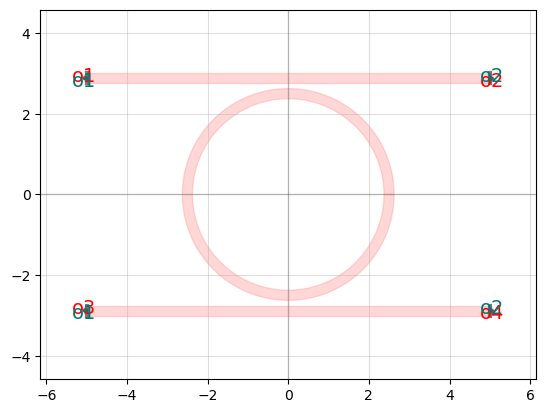

2024-04-21 10:48:51.620 | INFO     | gdsfactory.component:_write_library:2003 - Wrote to 'ring.gds'
Cell names: ring, ring_radius2p5_width0p25, straight_length10_width0p25
[<gdstk.Cell object at 0x7241efbb9590>, <gdstk.Cell object at 0x7241efbb9f10>, <gdstk.Cell object at 0x7241efbb99d0>]
Cell 'ring' with 0 polygons, 0 flexpaths, 0 robustpaths, 3 references, and 0 labels


In [1]:
# Creat gds file using gdsfactory and load it with gdstk for tidy3d
import matplotlib.pyplot as plt
import gdsfactory as gf
import gdstk

@gf.cell
def ring() -> gf.Component:
    c = gf.Component("ring_resonator")
    ring = c << gf.components.ring(radius=2.5, width=0.25, angle_resolution=2.5, layer='WG', angle=360)
    straight1 = c << gf.components.straight(width=0.25,length=10)
    straight1.move([-5, 2.5 + 0.13 + 0.25])

    straight2 = c << gf.components.straight(width=0.25, length=10)
    straight2.move([-5, -2.5 - 0.13 - 0.25])

    c.add_port("o1", port=straight1.ports["o1"])
    c.add_port("o2", port=straight1.ports["o2"])
    c.add_port("o3", port=straight2.ports["o1"])
    c.add_port("o4", port=straight2.ports["o2"])
    return c


c = ring()
gf.remove_from_cache(c)
c.plot()

# c = gf.components.ring_single()
c.write_gds("ring.gds")

# # Load a GDSII library from the file we just created
lib_loaded = gdstk.read_gds("ring.gds")

# Create a cell dictionary with all the cells in the file
all_cells = {c.name: c for c in lib_loaded.cells}

print("Cell names: " + ", ".join(all_cells.keys()))

print(lib_loaded.cells)

coup_cell_loaded = all_cells[c.name]

print(coup_cell_loaded)

In [11]:
scene = c.to_3d()
scene.show()

In [2]:
# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d.web as web
import tidy3d as td

# tidy3D plugins
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_ms

# wavelength range of interest
lambda_beg = 0.5
lambda_end = 0.6

# define pulse parameters
freq_beg = td.C_0 / lambda_end
freq_end = td.C_0 / lambda_beg
freq0 = (freq_beg + freq_end) / 2
fwidth = (freq_end - freq0) / 1.5

min_steps_per_wvl = 30
run_time = 15e-12

# define geometry
wg_width = 0.25
couple_width = 0.13
ring_radius = 2.5
ring_wg_width = 0.25
wg_spacing = 0.5
buffer = 1.0

# compute quantities based on geometry parameters
x_span = 2 * ring_radius + 2 * buffer
y_span = 2 * ring_radius + 2*ring_wg_width + 2*wg_width + 2*couple_width + 2 * buffer
sim_center_y = (couple_width + wg_width) / 2
wg_insert_x = ring_radius + wg_spacing
wg_center_y = ring_radius + ring_wg_width / 2.0 + couple_width + wg_width / 2.0

n_bg = 1.0
n_solid = 1.5
background = td.Medium(permittivity=n_bg**2)
solid = td.Medium(permittivity=n_solid**2)


# waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, wg_center_y, 0],
        size=[td.inf, wg_width, td.inf],
    ),
    medium=solid,
    name="waveguide",
)


mode_plane = td.Box(
    center=[-wg_insert_x, wg_center_y, 0],
    size=[0, 2, td.inf],
)

sim_modesolver = td.Simulation(
    center=[0, sim_center_y, 0],
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=min_steps_per_wvl, wavelength=td.C_0 / freq0
    ),
    structures=[waveguide],
    run_time=1e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.Periodic()),
    medium=background,
)

mode_spec = td.ModeSpec(num_modes=2)
mode_solver = ModeSolver(
    simulation=sim_modesolver, plane=mode_plane, mode_spec=mode_spec, freqs=[freq0]
)
mode_data = run_ms(mode_solver)

10:48:56 CEST Mode solver created with                                          
              task_id='fdve-97911458-728b-4246-8963-88ba33100e32',              
              solver_id='mo-5b5101fd-404d-4762-b7fe-f65927e86d06'.

Output()

Output()

10:49:00 CEST Mode solver status: queued

10:49:03 CEST Mode solver status: running

10:49:10 CEST Mode solver status: success

Output()

wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
5.496195e+14 0             0.545455  1.348764    0.0      4.924683e-14   
             1             0.545455  1.271592    0.0      1.000000e+00   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
5.496195e+14 0                 1.000000        0.882221   0.309923  
             1                 0.789232        1.000000   0.454009

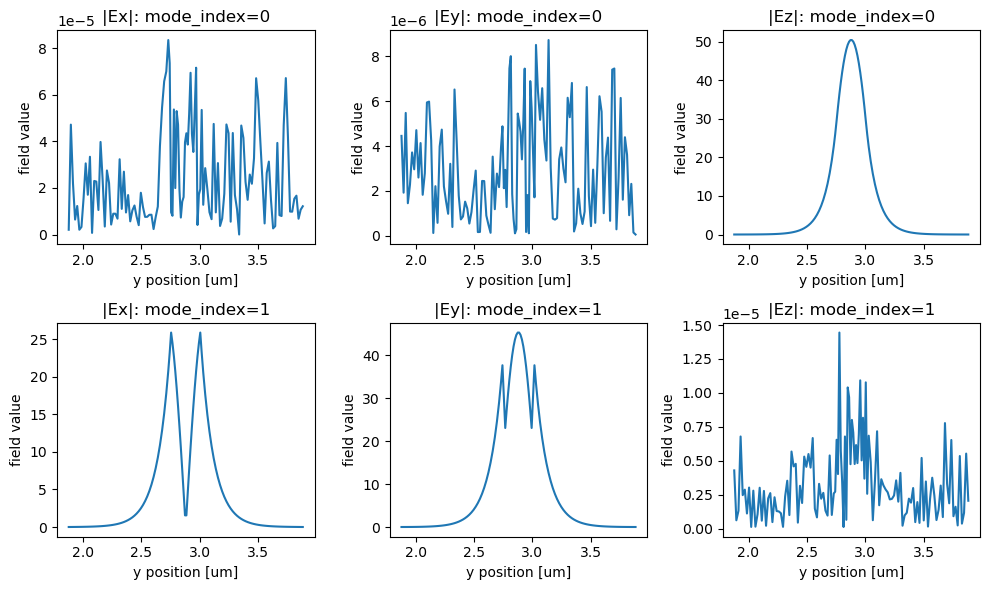

In [3]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    2, 3, tight_layout=True, figsize=(10, 6)
)
mode_data.Ex.sel(mode_index=0, f=freq0).abs.plot(ax=ax1)
mode_data.Ey.sel(mode_index=0, f=freq0).abs.plot(ax=ax2)
mode_data.Ez.sel(mode_index=0, f=freq0).abs.plot(ax=ax3)
mode_data.Ex.sel(mode_index=1, f=freq0).abs.plot(ax=ax4)
mode_data.Ey.sel(mode_index=1, f=freq0).abs.plot(ax=ax5)
mode_data.Ez.sel(mode_index=1, f=freq0).abs.plot(ax=ax6)
ax1.set_title("|Ex|: mode_index=0")
ax2.set_title("|Ey|: mode_index=0")
ax3.set_title("|Ez|: mode_index=0")
ax4.set_title("|Ex|: mode_index=1")
ax5.set_title("|Ey|: mode_index=1")
ax6.set_title("|Ez|: mode_index=1")

mode_data.to_dataframe()

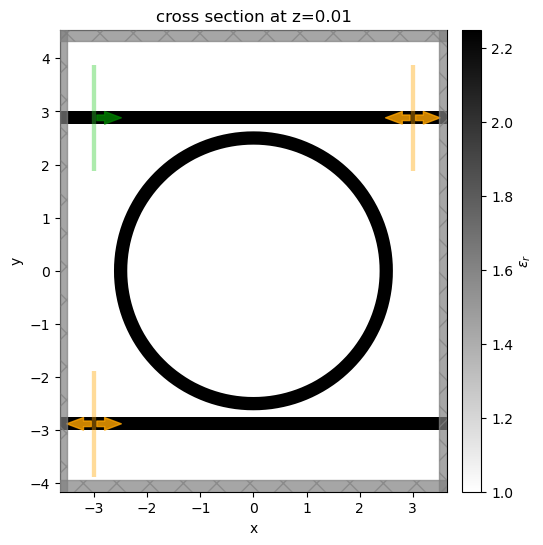

In [19]:
d_ring = td.Geometry.from_gds(
    gds_cell=coup_cell_loaded,
    axis=2,
    slab_bounds=(-0.125, 0.125),
    gds_layer=1,
)

ring_structure = td.Structure(
    geometry=d_ring, medium=solid,
)

mode_source = td.ModeSource(
    size=mode_plane.size,
    center=mode_plane.center,
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    mode_spec=td.ModeSpec(num_modes=2),
    mode_index=1,
    direction="+",
    num_freqs=11,  # using 11 (Chebyshev) points to approximate frequency dependence
)

# monitor steady state fields at central frequency over whole domain
field_monitor = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, td.inf, 0], freqs=[freq0], name="field"
)

# monitor the mode amps on the output waveguide
lambdas_measure = np.linspace(lambda_beg, lambda_end, 1001)
freqs_measure = td.C_0 / lambdas_measure[::-1]

mode_monitor = td.ModeMonitor(
    size=mode_plane.size,
    center=mode_plane.center,
    freqs=freqs_measure,
    mode_spec=td.ModeSpec(num_modes=2),
    name="mode",
)

# lets reset the center to the on the right hand side of the simulation though
mode_monitor_1 = mode_monitor.copy(update=dict(center=[wg_insert_x, wg_center_y, 0], name = "mode1"))
mode_monitor_2 = mode_monitor.copy(update=dict(center=[-wg_insert_x, -wg_center_y, 0], name = "mode2"))

# create simulation
sim = td.Simulation(
    center=[0, sim_center_y, 0],
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=min_steps_per_wvl, wavelength=td.C_0 / freq0
    ),
    structures=[ring_structure],
    sources=[mode_source],
    monitors=[field_monitor, mode_monitor_1, mode_monitor_2],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.periodic()
    ),
    medium=background,
    shutoff=1e-9,
)


# plot the two simulations
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sim.plot_eps(z=0.01, ax=ax)
plt.show()



In [20]:
job = web.Job(simulation=sim, task_name="ring_resonator", verbose=True)

# estimate the maximum cost
estimated_cost = web.estimate_cost(job.task_id)

13:03:46 CEST Created task 'ring_resonator' with task_id                        
              'fdve-d5ab2cd9-9f13-431d-8c15-da9aaf502f1d' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=999048;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5ab2cd9-9f13-431d-8c15-da9aaf502f1d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=583831;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5ab2cd9-9f13-431d-8c15-da9aaf502f1d\taskId]8;;\]8;id=999048;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5ab2cd9-9f13-431d-8c15-da9aaf502f1d\=]8;;\]8;id=268884;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5ab2cd9-9f13-431d-8c15-da9aaf502f1d\fdve]8;;\]8;id=999048;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5ab2cd9-9f13-431d-8c15-da9aaf502f1d\-d5ab2cd9-9f]8;;\
              ]8;id=999048;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5ab2cd9-9f13-431d-8c15-da9aaf502f1d\13-431d-8c15-da9aaf502f1d']8;;\.

Output()

13:03:49 CEST Maximum FlexCredit cost: 0.277. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

In [21]:
# use function above to run simulation
sim_data = web.run(
    sim, task_name="ring_resonator", path="data/ring.hdf5", verbose=True
)

13:04:34 CEST Created task 'ring_resonator' with task_id                        
              'fdve-99a41dfa-686d-48e4-8f31-37f8b57a186c' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=185577;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99a41dfa-686d-48e4-8f31-37f8b57a186c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=206389;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99a41dfa-686d-48e4-8f31-37f8b57a186c\taskId]8;;\]8;id=185577;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99a41dfa-686d-48e4-8f31-37f8b57a186c\=]8;;\]8;id=744218;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99a41dfa-686d-48e4-8f31-37f8b57a186c\fdve]8;;\]8;id=185577;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99a41dfa-686d-48e4-8f31-37f8b57a186c\-99a41dfa-68]8;;\
              ]8;id=185577;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99a41dfa-686d-48e4-8f31-37f8b57a186c\6d-48e4-8f31-37f8b57a186c']8;;\.

Output()

13:04:40 CEST status = queued

Output()

13:04:44 CEST status = preprocess

13:04:48 CEST Maximum FlexCredit cost: 0.277. Use 'web.real_cost(task_id)' to   
              get the billed FlexCredit cost after a simulation run.

              starting up solver

              running solver

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:14:27 CEST early shutoff detected at 40%, exiting.

              status = postprocess

Output()

13:14:32 CEST status = success

              View simulation result at                                         
              ]8;id=632296;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99a41dfa-686d-48e4-8f31-37f8b57a186c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=683126;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99a41dfa-686d-48e4-8f31-37f8b57a186c\taskId]8;;\]8;id=632296;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99a41dfa-686d-48e4-8f31-37f8b57a186c\=]8;;\]8;id=924899;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99a41dfa-686d-48e4-8f31-37f8b57a186c\fdve]8;;\]8;id=632296;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99a41dfa-686d-48e4-8f31-37f8b57a186c\-99a41dfa-68]8;;\
              ]8;id=632296;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99a41dfa-686d-48e4-8f31-37f8b57a186c\6d-48e4-8f31-37f8b57a186c']8;;\.

Output()

13:14:48 CEST loading simulation from data/ring.hdf5

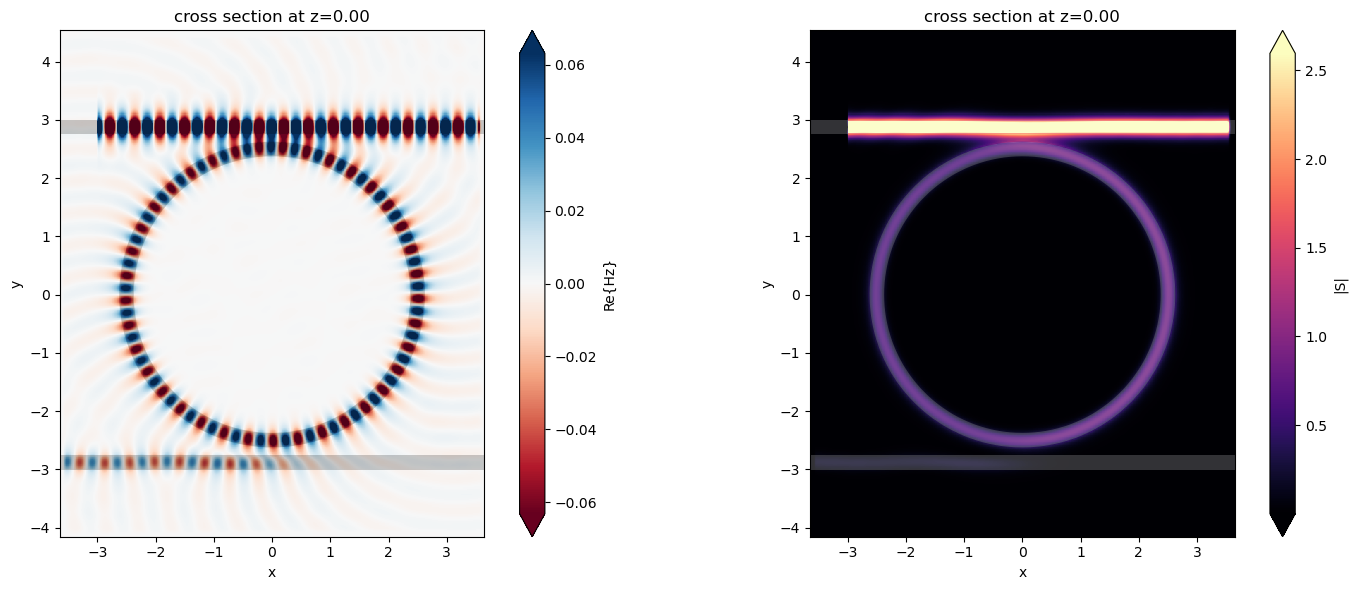

In [22]:
# visualize normalization run
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 6))

ax1 = sim_data.plot_field("field", "Hz", val="real", z=0, ax=ax1)
ax2 = sim_data.plot_field("field", "S", val="abs", z=0, ax=ax2)

plt.show()

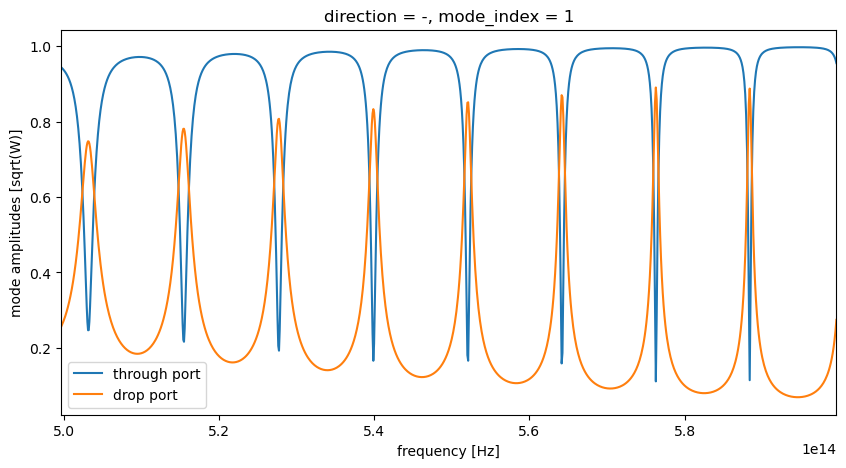

In [38]:
T1 = sim_data["mode1"].amps.sel(mode_index=1, direction="+")
T2 = sim_data["mode2"].amps.sel(mode_index=1, direction="-")

f, ax = plt.subplots(figsize=(10, 5))

T1.abs.plot.line(x="f", ax=ax, label="through port")
T2.abs.plot.line(x="f", ax=ax, label="drop port")
ax.set_xlim(freqs_measure[0], freqs_measure[-1])
ax.legend()

plt.show()